In [1]:
# GraphQL and I/O related
from pprint import pprint
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import json

# statistical analysis
import pandas as pd
# from pandas import Timestamp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math

In [2]:
uniswap_v3_subgraph_url = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"

### Replicating the Info Page
We perform the following two queries over 1000 days (at most):
1. TVL
2. 24H Volume

In [3]:
POOL_CHART = gql(
    """
    query poolDayDatas($startTime: Int!, $skip: Int!, $address: String!) {
        poolDayDatas(
            first: 1000
            skip: $skip
            where: { pool: $address, date_gt: $startTime }
            orderBy: date
            orderDirection: asc
            subgraphError: allow
        ) {
            date
            volumeUSD
            tvlUSD
            feesUSD
        }
    }
    """
)

In [4]:
# ref: https://github.com/Uniswap/v3-info/blob/770a05dc1a191cf229432ebc43c1f2ceb3666e3b/src/data/pools/chartData.ts#L14
async def fetch_pool_chart_data(address: str, verbose: bool=False):
    START_TIMESTAMP = 1619170975 # GMT: Friday, April 23, 2021 9:42:55 AM
    # END_TIMESTAMP = int(time.time()) # current timestamp

    error = False
    skip = 0
    all_found = False
    result = {"poolDayDatas": []}

    transport = AIOHTTPTransport(url=uniswap_v3_subgraph_url)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        params = {
            "address": address,
            "startTime": START_TIMESTAMP,
            "skip": skip
        }
        try:
            while not all_found:
                temp = await session.execute(POOL_CHART, variable_values=params)
                skip += 1000
                if len(temp["poolDayDatas"]) < 1000 or error:
                    all_found = True
                if temp:
                    result["poolDayDatas"] = result["poolDayDatas"] + temp["poolDayDatas"] # concat the lists
        except:
            error = True
            print("Error!")

    if verbose:
        pprint(result)

    poolDayDatas = json.dumps(result, indent=4)
    with open('poolDayDatas.json', 'w') as file:
        file.write(poolDayDatas)

In [5]:
pool_addr = "0x5777d92f208679db4b9778590fa3cab3ac9e2168" # DAI/USDC
# await fetch_pool_chart_data(pool_addr, verbose=True)

In [6]:
# reads pool day datas from json
with open('poolDayDatas.json', 'r') as file:
    pool_day_datas = json.load(file)

# parse dict as df
df = pd.DataFrame.from_dict(pool_day_datas["poolDayDatas"])

# Note: there is no need to analyze fees separately,
# as it is a fixed proportion of the pool's trade volume
df.drop(columns=["feesUSD"], inplace=True)

df.head()

,date,volumeUSD,tvlUSD
0,1636761600,451384.6317736593532386940623125507,196699.286342662913455987
1,1636848000,304642.996682467277186022285102527,208034.458676277547941412
2,1636934400,483612.6948624568593532362423753129,208080.951216703931612544
3,1637020800,4258825.591757019697420176796614061,208506.295394776311376604
4,1637107200,43315350.56612111798324184497370248,7504937.522720789919542294999999998


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       208 non-null    int64 
 1   volumeUSD  208 non-null    object
 2   tvlUSD     208 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.0+ KB


In [8]:
# set column types

# ["date"]: int -> date (in "YYYY-MM-DD")
df["timestamp"] = df["date"] # keep timestamp in a new col
df["date"] = df["date"].map(dt.date.fromtimestamp)

# ["volumeUSD", "tvlUSD"]: str -> np.float64
df["volumeUSD"] = df["volumeUSD"].astype(np.float64)
df["tvlUSD"] = df["tvlUSD"].astype(np.float64)

df.head()

,date,volumeUSD,tvlUSD,timestamp
0,2021-11-13,4.513846e+05,1.966993e+05,1636761600
1,2021-11-14,3.046430e+05,2.080345e+05,1636848000
2,2021-11-15,4.836127e+05,2.080810e+05,1636934400
3,2021-11-16,4.258826e+06,2.085063e+05,1637020800
4,2021-11-17,4.331535e+07,7.504938e+06,1637107200


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       208 non-null    object 
 1   volumeUSD  208 non-null    float64
 2   tvlUSD     208 non-null    float64
 3   timestamp  208 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.6+ KB


In [10]:
# sanity check for number of days elapsed
print(df["date"][0], "to", dt.date.today(), "has", (dt.date.today() - df["date"][0]))

2021-11-13 to 2022-06-10 has 209 days, 0:00:00


## 24H Volume Analysis

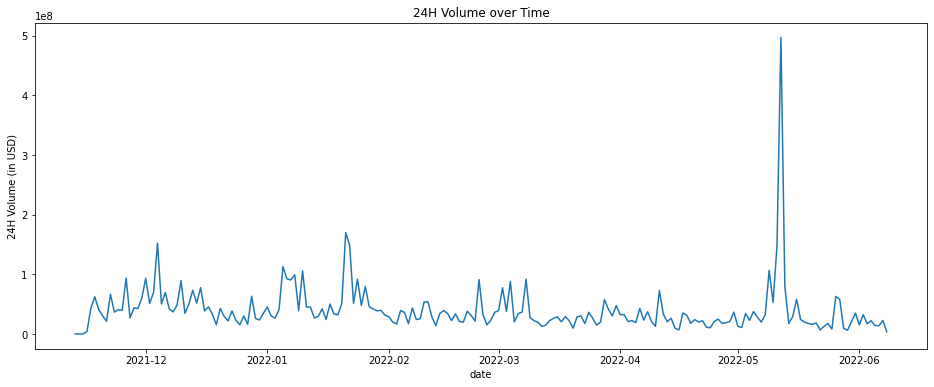

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(df["date"], df["volumeUSD"])
plt.title("24H Volume over Time")
plt.xlabel("date")
plt.ylabel("24H Volume (in USD)")
plt.show()

In [12]:
# find the days with the greatest 24H volumes
df.sort_values(by="volumeUSD", ascending=False)[:10]

,date,volumeUSD,tvlUSD,timestamp
180,2022-05-12,4.970918e+08,3.438614e+08,1652313600
69,2022-01-21,1.700231e+08,5.269889e+07,1642723200
21,2021-12-04,1.525008e+08,4.713907e+07,1638576000
70,2022-01-22,1.491131e+08,5.272328e+07,1642809600
179,2022-05-11,1.485899e+08,3.479251e+08,1652227200
53,2022-01-05,1.132481e+08,5.766949e+07,1641340800
177,2022-05-09,1.068422e+08,3.503956e+08,1652054400
58,2022-01-10,1.062241e+08,6.030003e+07,1641772800
56,2022-01-08,9.929644e+07,6.016817e+07,1641600000
13,2021-11-26,9.393596e+07,9.234947e+06,1637884800


#### Observation
2022-05-12: Luna & UST crash

2022-01-21: (tbc)

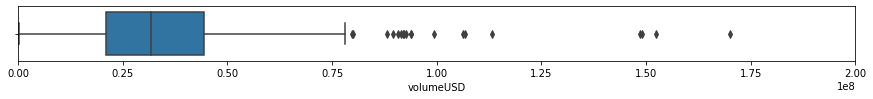

In [13]:
# for reference only, no use now
fig, ax = plt.subplots(figsize=(15, 1))
sns.boxplot(data=df, x="volumeUSD")
plt.xlim(0, 2e8)
plt.show()

### Histogram
Observe the distribution of the prices.

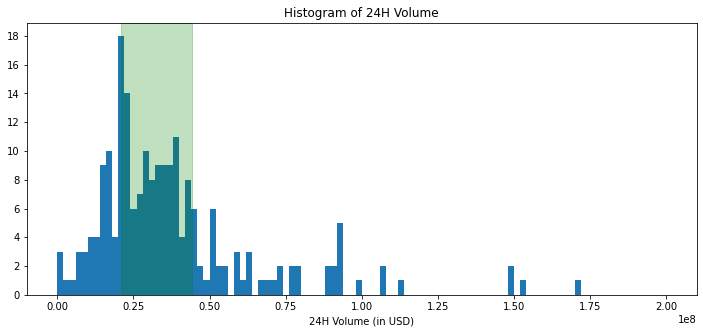

In [14]:
from matplotlib.pyplot import MaxNLocator
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df["volumeUSD"], bins=100, range=(0, 2e8))

# force y-axis ticks to use integers
ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
plt.title("Histogram of 24H Volume")
plt.xlabel("24H Volume (in USD)")

# highlight 25%-75% percentile
lq = df["volumeUSD"].quantile(0.25)
uq = df["volumeUSD"].quantile(0.75)
ax.axvspan(lq, uq, color="green", alpha=0.25)

plt.show()

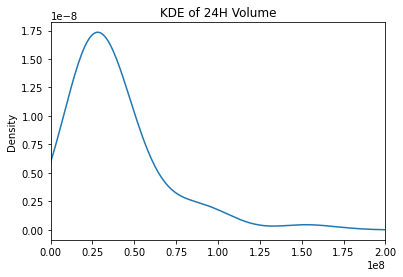

In [15]:
# for reference only, no use now
df["volumeUSD"].plot.kde()
plt.title("KDE of 24H Volume")
plt.xlim(0, 2e8)
plt.show()

In [16]:
# TODO: time series / autocorelation
# TODO: aggregate weekly and daily patterns and look for anomalies (e.g. Friday)
# TODO: see if wavelet analysis is useful
# TODO: ask for calculation of Greeks (Detla, Vega...)

In [17]:
# TODO: compare DFT and FFT

### Fast Fourier Transform (FFT)
FFT computes the frequency content of the prices as signals.

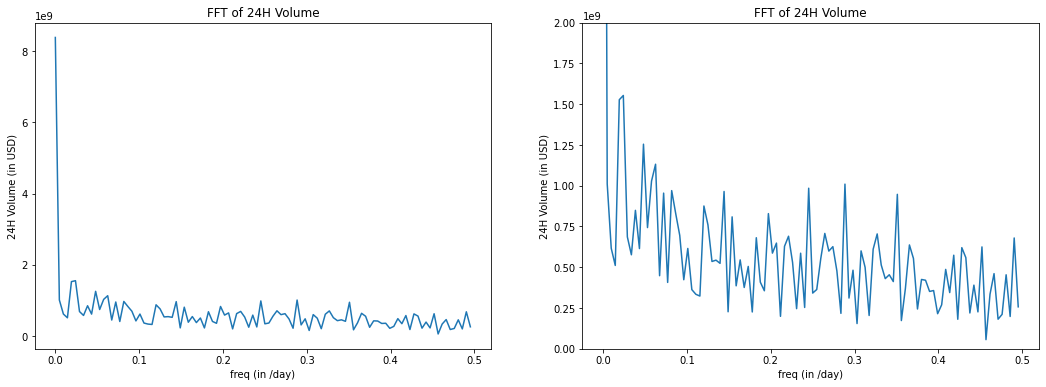

In [18]:
# only keep those with freq >= 0
Y = abs(np.fft.fft(df["volumeUSD"]))[0:math.ceil(df.shape[0]/2)]
freq = np.fft.fftfreq(df.shape[0], 1)[0:math.ceil(df.shape[0]/2)]

# plot the pool data
fig, ax = plt.subplots(figsize=(18, 6))

# plot 1: 24H volume
plt.subplot(1, 2, 1)
plt.plot(freq, Y)
plt.title("FFT of 24H Volume")
plt.xlabel("freq (in /day)")
plt.ylabel("24H Volume (in USD)")

# plot 2: TVL
plt.subplot(1, 2, 2)
plt.plot(freq, Y)
plt.ylim(0, 2e9)
plt.title("FFT of 24H Volume")
plt.xlabel("freq (in /day)")
plt.ylabel("24H Volume (in USD)")

plt.show()

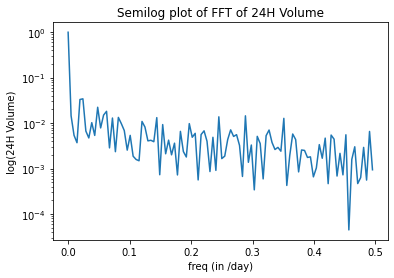

In [19]:
# get the list of spectrums
spectrum = Y.real*Y.real + Y.imag*Y.imag
nspectrum = spectrum / spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
plt.semilogy(freq, nspectrum)
plt.title("Semilog plot of FFT of 24H Volume")
plt.xlabel("freq (in /day)")
plt.ylabel("log(24H Volume)")
plt.show()

## TVL Analysis

In [20]:
import pwlf_helper
reg_result = pwlf_helper.regression(df["timestamp"], df["tvlUSD"], 6)

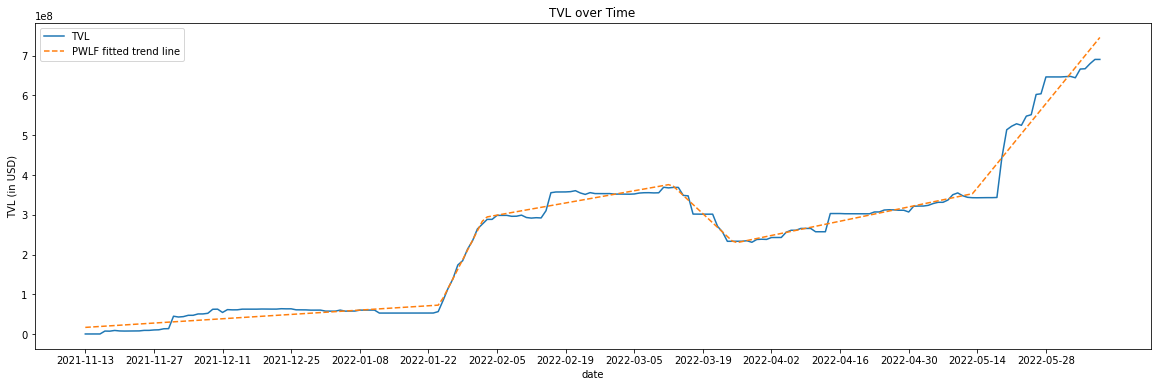

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(df["date"], df["tvlUSD"])
plt.plot(df["date"], reg_result.yHat, '--')

# x-axis ticks are spaced out biweekly (for now)
plt.xticks(pd.date_range(df["date"].iloc[0], df["date"].iloc[-1], freq="14D"))

plt.title("TVL over Time")
plt.xlabel("date")
plt.ylabel("TVL (in USD)")
plt.legend(["TVL", "PWLF fitted trend line"])
plt.show()

In [22]:
# get turning points (in date)
tps = [dt.date.fromtimestamp(tp).strftime("%Y-%m-%d") for tp in reg_result.tp]
print(tps)

['2021-11-13', '2022-01-24', '2022-02-02', '2022-03-12', '2022-03-25', '2022-05-13', '2022-06-08']
